#   Data

In [1]:
#Paths to data
train_path= '/kaggle/input/kermany2018/OCT2017 /train/'
val_path= '/kaggle/input/kermany2018/OCT2017 /val/'
test_path= '/kaggle/input/kermany2018/OCT2017 /test/'


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, ReLU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import itertools

# Preprocessing

In [3]:
#Calculate class weight for the imbalanced data
#The class weight is calculated by taking the inverse of the class frequency 
total = 83484

count_cnv = 37205
count_dme = 11348
count_drusen = 8616
count_normal = 26315

cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)

class_weight = {0 : cnv_weight, 1: dme_weight, 2 : drusen_weight, 3: norm_weight}
print(class_weight)

{0: 0.5609729875016799, 1: 1.839178709904829, 2: 2.4223537604456826, 3: 0.7931217936538096}


In [ ]:
#loading data
labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

def load(path):
    listed_paths = []
    for i in labels:
        base_path = os.path.join(path, i)
        imgs = os.listdir(base_path)
        for img in imgs:
            img_path = base_path + '/' + img
            listed_paths.append(img_path)
    return listed_paths

train_paths = load(train_path)
val_paths = load(val_path)
test_paths = load(test_path)


# Show sample

Train has 83484 images
Validation has 32 images
test has 968 images


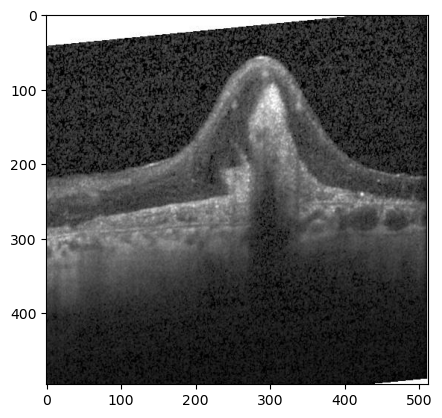

In [4]:
#Sample
print("Train has " + str(len(train_paths)) + " images")
img1 = cv2.imread(train_paths[8000])
plt.imshow(img1)

print("Validation has " + str(len(val_paths)) + " images")

print("test has " + str(len(test_paths)) + " images")


# Data augmentation

In [5]:
train_datagen = ImageDataGenerator(
    
    rescale= 1./255, # rescale pixel values to [0,1]
    
    zoom_range= (0.73, 0.9), # randomly zoom images 
    
    horizontal_flip= True, # randomly flip images horizontally
    
    rotation_range= 10, # randomly rotate images by up to 20 degrees
    
    width_shift_range= 0.10, # randomly shift images horizontally by up to 10%
    
    fill_mode= 'constant', # fill any empty pixels with constant
    
    height_shift_range= 0.10,   # randomly shift images vertically by up to 10% 
    
    brightness_range= (0.55, 0.9), # modify the brightness
    
    shear_range=0.2,       # randomly shear images by up to 20%
)

train_generator = train_datagen.flow_from_directory(  
    
    train_path,  #data to read
    
    target_size= (150, 150), #resized
    
    color_mode= 'rgb', #full colored images
    
    batch_size= 64,  
    
    class_mode= 'categorical', #for multicalsses classification
    
    shuffle= True, #for the over fitting problem
    
    seed= 1337
)

Found 83484 images belonging to 4 classes.


In [6]:
val_datagen = ImageDataGenerator(
    
    rescale= 1./255, # rescale pixel values to [0,1]
    
    zoom_range= (0.73, 0.9), # randomly zoom images 
    
    horizontal_flip= True, # randomly flip images horizontally
    
    rotation_range= 10, # randomly rotate images by up to 20 degrees
    
    width_shift_range= 0.10, # randomly shift images horizontally by up to 10%
    
    fill_mode= 'constant', # fill any empty pixels with constant
    
    shear_range=0.2,       # randomly shear images by up to 20%

    height_shift_range= 0.10, # randomly shift images vertically by up to 10%  
    
    brightness_range= (0.55, 0.9), # modify the brightness
)

val_generator = val_datagen.flow_from_directory(  
    val_path,  
    
    target_size= (150, 150), 
    
    color_mode= 'rgb',
    
    batch_size= 64,  
    
    class_mode= 'categorical',
    
    shuffle= True, 
    
    seed= 1337
)

Found 32 images belonging to 4 classes.


In [7]:
test_datagen = ImageDataGenerator(
    
    rescale= 1./255, # rescale pixel values to [0,1]
    
    zoom_range= (0.73, 0.9), # randomly zoom images
    
    horizontal_flip= True, # randomly flip images horizontally
    
    rotation_range= 10, # randomly rotate images by up to 20 degrees
    
    width_shift_range= 0.10, # randomly shift images horizontally by up to 10%
    
    fill_mode= 'constant', # fill any empty pixels with constant
    
    height_shift_range= 0.10,   # randomly shift images vertically by up to 10%  
    
    brightness_range= (0.55, 0.9), # modify the brightness
    
    shear_range=0.2,       # randomly shear images by up to 20%
)

test_generator = test_datagen.flow_from_directory( 
    
    test_path,  
    
    target_size= (150, 150), 
    
    color_mode= 'rgb',
    
    batch_size= 64,  
    
    class_mode= 'categorical',
    
    shuffle= True, 
    
    seed= 1337
)

Found 968 images belonging to 4 classes.


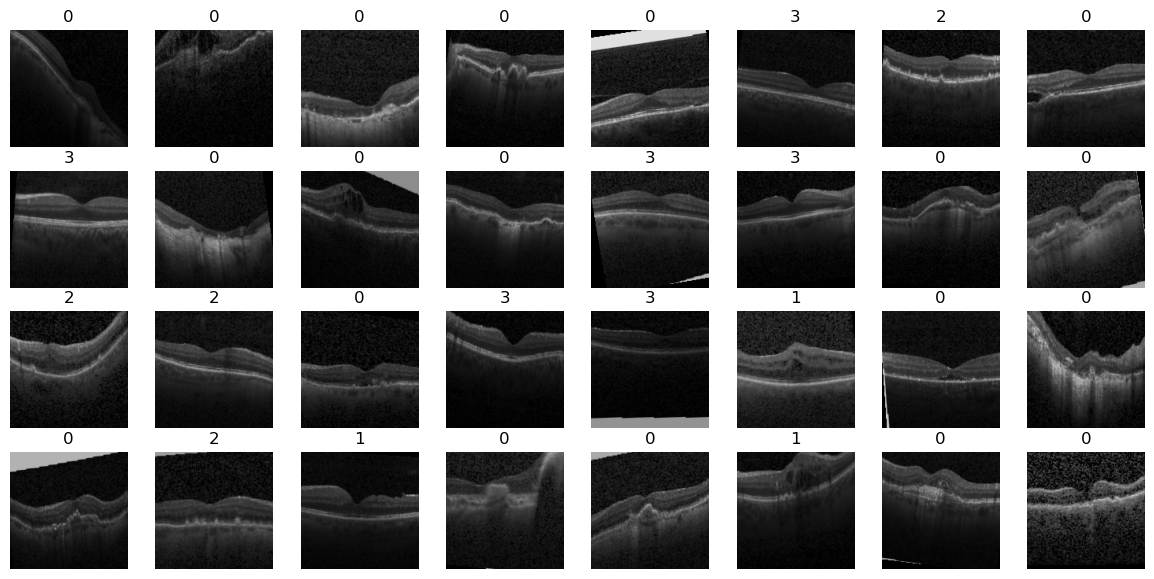

In [8]:
#data samples
batch_images, batch_labels = train_generator.next()

fig, axs = plt.subplots(4, 8, figsize=(15, 7))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(batch_images[i])
    axs[i].set_title(np.argmax(batch_labels[i]))
    axs[i].axis('off')
plt.show()

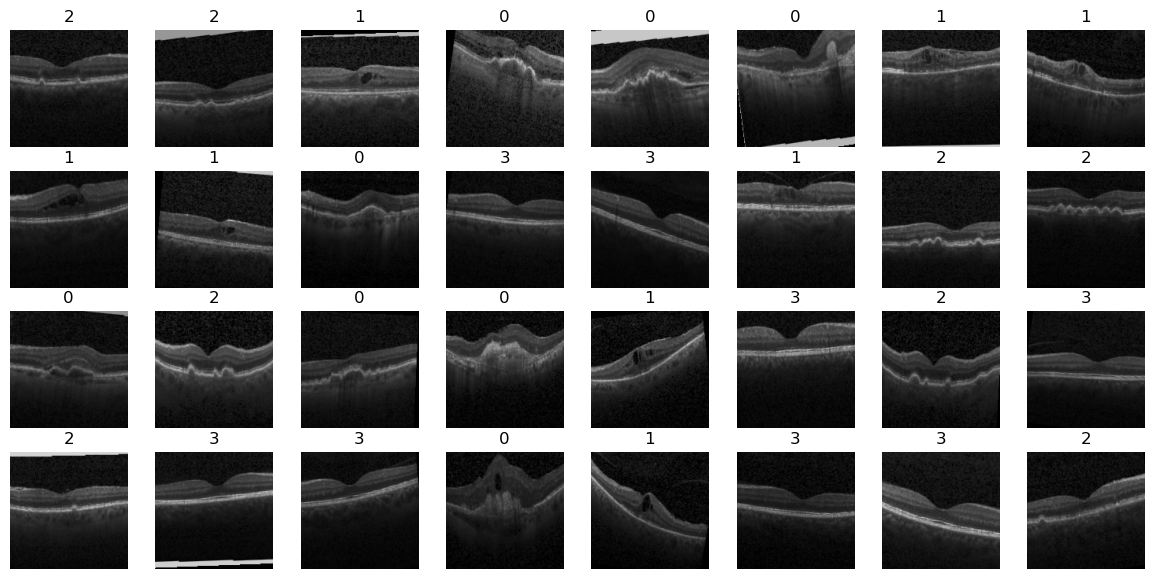

In [9]:
batch_images, batch_labels = val_generator.next()

fig, axs = plt.subplots(4, 8, figsize=(15, 7))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(batch_images[i])
    axs[i].set_title(np.argmax(batch_labels[i]))
    axs[i].axis('off')
plt.show()

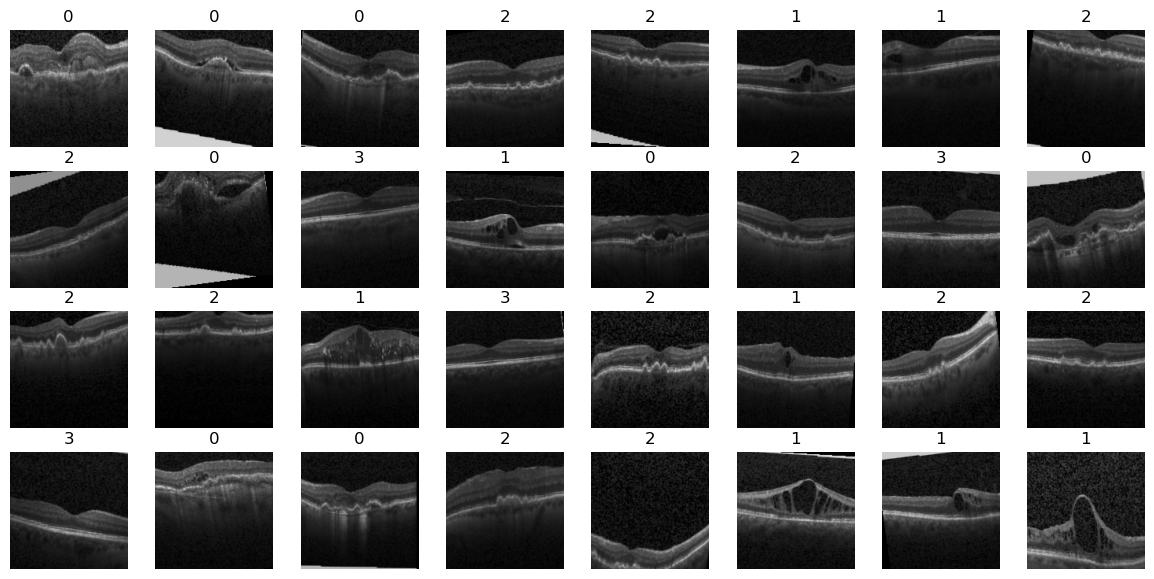

In [10]:
batch_images, batch_labels = test_generator.next()

fig, axs = plt.subplots(4, 8, figsize=(15, 7))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(batch_images[i])
    axs[i].set_title(np.argmax(batch_labels[i]))
    axs[i].axis('off')
plt.show()

# vgg16 vs inceptionv3

The VGG16 and InceptionV3 models are both popular convolutional neural network models used in deep learning for computer vision applications. Here are some differences between the two:

Architecture: VGG16 has a simpler architecture compared to InceptionV3, with only stacked 3x3 convolutional layers and max pooling layers. InceptionV3, on the other hand, uses a combination of 1x1, 3x3, and 5x5 convolutional layers with max pooling layers.

Number of Parameters: VGG16 has more parameters (138 million) compared to InceptionV3 (23 million), due to its simpler architecture and larger number of fully connected layers.

Training Speed: InceptionV3 is faster to train compared to VGG16 because of its use of smaller filters in the convolutional layers, which reduces the number of parameters and computation.

Accuracy: InceptionV3 tends to perform better than VGG16 on datasets with a larger number of classes and more complex image recognition tasks.

In general, the choice between VGG16 and InceptionV3 depends on the specific task and dataset. It is recommended to try both models and compare their performance on the specific task at hand.

# Build the Model VGG16


1. optimizer => `ADAM`
2. loss function => categorical_crossentropy
3. filter 3x3 for all convolutional layers, increases as we go deeper into the network. 
4. `learning rate` for ADAM optimizer `0.0001`
5. the VGG16 model will be fine-tuned some layers depend on the Number of `trainable_layers`
6. `epoch` number choice by `early_stop` = 24
7. `batch size` = 64
8. `accuracy` => training = 0.9038, validating = 1.0, Testing = 0.97
9. `loss` => training = 0.2792, validating = 0.0401, Testing = 0.0963
10. `steps_per_epoch` the  model i set it by `100`  
> `steps_per_epoch` is calculated as the total number of training samples divided by the batch size.
 it's important to ensure that the number of steps_per_epoch is not too small, as this may lead to underfitting.

## Building

In [11]:
# pre-trained VGG16 model

#weights :  load its pre-trained weights from the 'imagenet' dataset
#include_top=False : to remove the fully connected layer at the top of the network
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
# adding new trainable layers on top can help prevent overfitting
trainable_layers = len(base_model.layers[:-5])
for layer in base_model.layers[:trainable_layers]:
    layer.trainable = False # Freeze the weights of all layers except for the last 5
for layer in base_model.layers[trainable_layers:]:
    layer.trainable = True

In [12]:
num_classes = 4

In [13]:
# Add new classification layers on top of the pre-trained layers

#Flatten the 3D output into a 1D feature vector using Flatten(), and feed it into a dense layer with 256 hidden units and a ReLU activation
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Add a dropout layer with a rate of 0.5 to prevent overfitting
predictions = Dense(num_classes, activation='softmax')(x)
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [15]:
# Compile the model with Adam optimizer
opt = Adam(lr=0.0001)
#loss='categorical_crossentropy', this is a commonly used loss function for multiclass classification problems
#The optimizer Adam is particularly effective in problems with large datasets and when the gradients are sparse or noisy.
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
# Define the callbacks

# ReduceLROnPlateau monitors a specified metric during training and reduces the learning rate of the optimizer if the metric does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# EarlyStopping stops training early if the metric does not improve
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [17]:
# Train the model

# steps_per_epoch specifies how many batches of training data to process per epoch.
epochs = 30
history = model.fit(train_generator,
                              epochs = epochs,
                              steps_per_epoch = 100,
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              callbacks = [reduce_lr, early_stop])

Epoch 1/30
100/100 [==============================] - 70s 653ms/step - loss: 0.6458 - accuracy: 0.7647 - val_loss: 0.1948 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 2/30
100/100 [==============================] - 62s 624ms/step - loss: 0.4212 - accuracy: 0.8517 - val_loss: 0.1358 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/30
100/100 [==============================] - 63s 628ms/step - loss: 0.3943 - accuracy: 0.8637 - val_loss: 0.0974 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/30
100/100 [==============================] - 63s 628ms/step - loss: 0.3281 - accuracy: 0.8892 - val_loss: 0.0903 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 5/30
100/100 [==============================] - 62s 621ms/step - loss: 0.3240 - accuracy: 0.8861 - val_loss: 0.0946 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 6/30
100/100 [==============================] - 62s 620ms/step - loss: 0.3060 - accuracy: 0.8964 - val_loss: 0.0731 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 7/30
100/100 [========

## Charts

In [18]:
# Predict probabilities for test set
test_probabilities = model.predict(test_generator)

# Compute ROC curve and AUC for each class
fpr_model = dict()
tpr_model = dict()
roc_auc_model = dict()
for i in range(num_classes):
    fpr_model[i], tpr_model[i], _ = roc_curve(test_generator.classes == i, test_probabilities[:, i])
    roc_auc_model[i] = auc(fpr_model[i], tpr_model[i])

# Compute Precision-Recall curve and AUC for each class
precision_model = dict()
recall_model = dict()
pr_auc_model = dict()
for i in range(num_classes):
    precision_model[i], recall_model[i], _ = precision_recall_curve(test_generator.classes == i, test_probabilities[:, i])
    pr_auc_model[i] = auc(recall_model[i], precision_model[i])
    
# Compute f1 score for each class
f1_scores_model = dict()
for i in range(num_classes):
    y_true = test_generator.classes == i
    y_pred = test_probabilities.argmax(axis=1) == i
    f1_scores_model[i] = f1_score(y_true, y_pred)


16/16 [==============================] - 10s 595ms/step


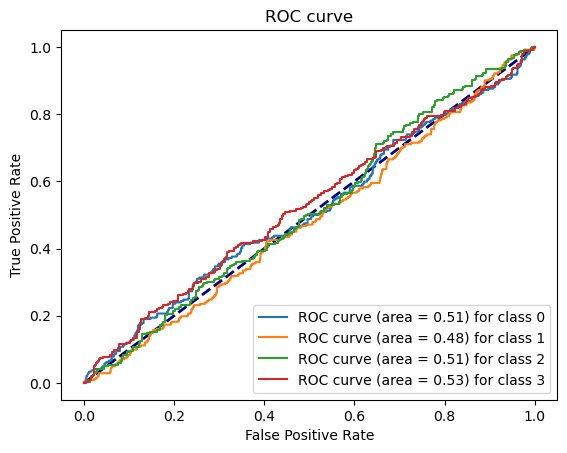

In [19]:
# Plot ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
for i in range(num_classes):
    plt.plot(fpr_model[i], tpr_model[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc_model[i], i))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

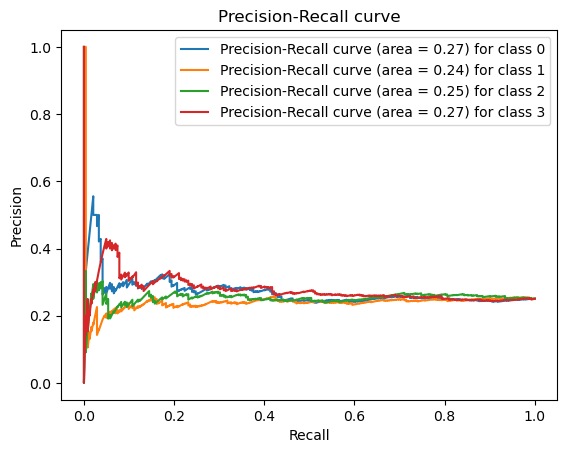

In [20]:
# Plot Precision-Recall curve
plt.figure()
for i in range(num_classes):
    plt.plot(recall_model[i], precision_model[i], label='Precision-Recall curve (area = %0.2f) for class %d' % (pr_auc_model[i], i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 299ms/step


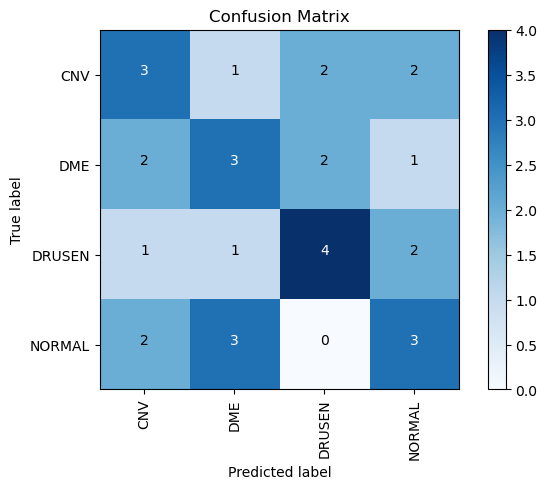

In [21]:
# Get the true labels for the validation set
y_true = val_generator.classes
# Get the predicted labels for the validation set
y_pred = model.predict_generator(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(y_pred, axis=1)    # convert from probabilities to class labels

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_generator.class_indices))
plt.xticks(tick_marks, val_generator.class_indices, rotation=90)
plt.yticks(tick_marks, val_generator.class_indices)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
# Smoothed curves for training and validation accuracy for fine-tuning
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

<Figure size 640x480 with 0 Axes>

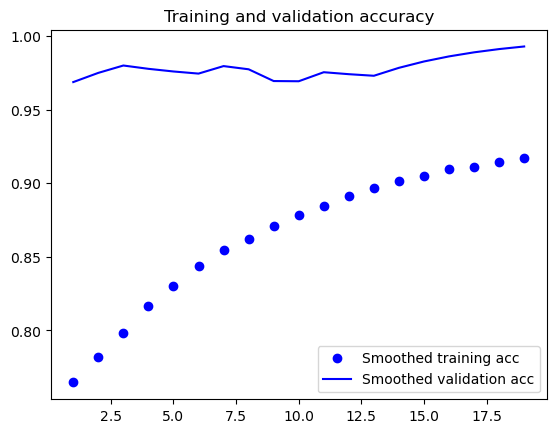

<Figure size 640x480 with 0 Axes>

In [23]:
# Create a new array of epoch values
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot the smoothed training and validation accuracy values against the epochs
plt.plot(epochs, smooth_curve(history.history['accuracy']), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(history.history['val_accuracy']), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

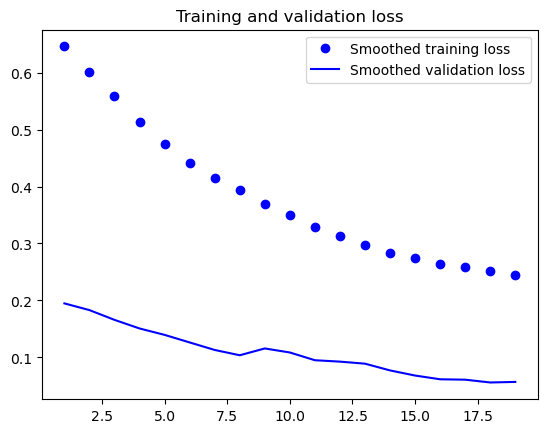

<Figure size 640x480 with 0 Axes>

In [24]:
# Create a new array of epoch values
epochs = range(1, len(history.history['loss']) + 1)

# Plot the smoothed training and validation accuracy values against the epochs
plt.plot(epochs, smooth_curve(history.history['loss']), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(history.history['val_loss']), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


## Calc the Acc

In [25]:
# Calculate the predictions on the validation set
val_generator.reset()
y_pred = model.predict(val_generator, steps=len(val_generator))
y_pred = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 291ms/step


In [26]:
# calculate precision, recall, f1-score, and support for each class
class_report = classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys())
print(class_report)

              precision    recall  f1-score   support

         CNV       0.25      0.25      0.25         8
         DME       0.62      0.62      0.62         8
      DRUSEN       0.12      0.12      0.12         8
      NORMAL       0.12      0.12      0.12         8

    accuracy                           0.28        32
   macro avg       0.28      0.28      0.28        32
weighted avg       0.28      0.28      0.28        32



# evaluate the model on the test data

In [27]:
# Evaluate the model on the train generator
train_loss, train_acc = sum(history.history['loss'])/len(history.history['loss']),sum(history.history['accuracy'])/len(history.history['accuracy'])
print("Train accuracy:", train_acc)
print("Train loss:", train_loss)
print(80 * '_')

# Evaluate the model on the validation generator
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print("Validation accuracy:", val_acc)
print("Validation loss:", val_loss)
print(80 * '_')

# Evaluate the model on the test generator
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

Train accuracy: 0.8970367845736051
Train loss: 0.29850925113025467
________________________________________________________________________________
Validation accuracy: 1.0
Validation loss: 0.03174137324094772
________________________________________________________________________________
Test accuracy: 0.9690082669258118
Test loss: 0.10618071258068085


In [28]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)

# Make predictions on the test set
test_generator.reset()
y_pred = model.predict(test_generator, verbose=1)
predictions = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute the precision, recall, and f1 score
print(classification_report(y_true, predictions))

16/16 [==============================] - 8s 505ms/step
              precision    recall  f1-score   support

           0       0.25      0.28      0.27       242
           1       0.27      0.27      0.27       242
           2       0.21      0.18      0.19       242
           3       0.22      0.23      0.22       242

    accuracy                           0.24       968
   macro avg       0.24      0.24      0.24       968
weighted avg       0.24      0.24      0.24       968



# Build the Model inceptionv3

1. optimizer => `ADAM`
2. loss function => categorical_crossentropy
3. filter 3x3 for all convolutional layers, increases as we go deeper into the network. 
4. `learning rate` for ADAM optimizer `0.0001`
5. the VGG16 model will be fine-tuned some layers depend on the Number of `trainable_layers`
6. `epoch` number choice by `early_stop` = 24
7. `batch size` = 64
---------------------------------
Train accuracy: 0.8218053340911865
Train loss: 0.4946177065372467
_________________________________
Validation accuracy: 0.8125
Validation loss: 0.4457867443561554
_________________________________
Test accuracy: 0.8564049601554871
Test loss: 0.3658451437950134

8. `steps_per_epoch` the  model i set it by `100`  
> `steps_per_epoch` is calculated as the total number of training samples divided by the batch size.
 it's important to ensure that the number of steps_per_epoch is not too small, as this may lead to underfitting.

In [29]:
# pre-trained inceptionv3 model
from keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
trainable_layers = len(base_model2.layers[:-5])
for layer in base_model2.layers[:trainable_layers]:
    layer.trainable = False # Freeze the weights of all layers except for the last 5
for layer in base_model2.layers[trainable_layers:]:
    layer.trainable = True

In [30]:
# Add new classification layers on top of the pre-trained layers
x = Flatten()(base_model2.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Add a dropout layer with a rate of 0.5
predictions = Dense(num_classes, activation='softmax')(x)
# Create the final model
model2 = Model(inputs=base_model2.input, outputs=predictions)

In [31]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [32]:
# Compile the model with Adam optimizer
opt = Adam(lr=0.0001)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [55]:
# Train the model
epochs = 30
history2 = model2.fit(train_generator,
                              epochs = epochs,
                              steps_per_epoch = 100,
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              callbacks = [reduce_lr, early_stop])

Epoch 1/30
100/100 [==============================] - 62s 622ms/step - loss: 0.4902 - accuracy: 0.8219 - val_loss: 0.3471 - val_accuracy: 0.8125 - lr: 1.0000e-05
Epoch 2/30
100/100 [==============================] - 63s 628ms/step - loss: 0.5063 - accuracy: 0.8178 - val_loss: 0.4088 - val_accuracy: 0.8438 - lr: 1.0000e-05
Epoch 3/30
100/100 [==============================] - 63s 627ms/step - loss: 0.4935 - accuracy: 0.8223 - val_loss: 0.4250 - val_accuracy: 0.8438 - lr: 1.0000e-05
Epoch 4/30
100/100 [==============================] - 63s 630ms/step - loss: 0.5105 - accuracy: 0.8125 - val_loss: 0.3050 - val_accuracy: 0.8438 - lr: 1.0000e-05
Epoch 5/30
100/100 [==============================] - 62s 624ms/step - loss: 0.4978 - accuracy: 0.8194 - val_loss: 0.2693 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 6/30
100/100 [==============================] - 62s 616ms/step - loss: 0.5013 - accuracy: 0.8193 - val_loss: 0.4237 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 7/30
100/100 [========

## Charts

In [57]:
# Predict probabilities for test set
test_probabilities = model2.predict(test_generator)

# Compute ROC curve and AUC for each class
fpr_model2 = dict()
tpr_model2 = dict()
roc_auc_model2 = dict()
for i in range(num_classes):
    fpr_model2[i], tpr_model2[i], _ = roc_curve(test_generator.classes == i, test_probabilities[:, i])
    roc_auc_model2[i] = auc(fpr_model2[i], tpr_model2[i])

# Compute Precision-Recall curve and AUC for each class
precision_model2 = dict()
recall_model2 = dict()
pr_auc_model2 = dict()
for i in range(num_classes):
    precision_model2[i], recall_model2[i], _ = precision_recall_curve(test_generator.classes == i, test_probabilities[:, i])
    pr_auc_model2[i] = auc(recall_model2[i], precision_model2[i])
    
# Compute f1 score for each class
f1_scores_model2 = dict()
for i in range(num_classes):
    y_true = test_generator.classes == i
    y_pred = test_probabilities.argmax(axis=1) == i
    f1_scores_model2[i] = f1_score(y_true, y_pred)


16/16 [==============================] - 9s 548ms/step


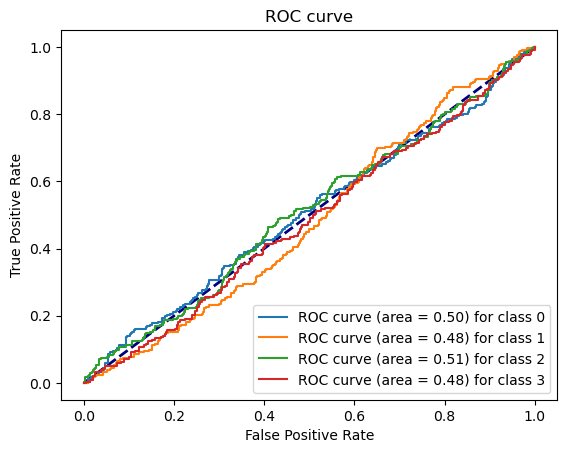

In [58]:
# Plot ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
for i in range(num_classes):
    plt.plot(fpr_model2[i], tpr_model2[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc_model2[i], i))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

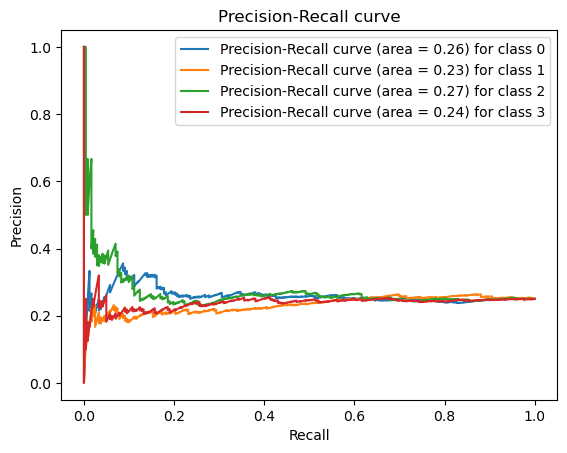

In [59]:
# Plot Precision-Recall curve
plt.figure()
for i in range(num_classes):
    plt.plot(recall_model2[i], precision_model2[i], label='Precision-Recall curve (area = %0.2f) for class %d' % (pr_auc_model2[i], i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 308ms/step


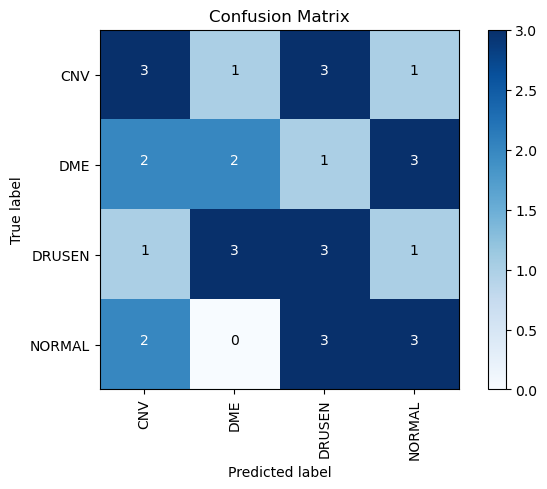

In [60]:
# Get the true labels for the validation set
y_true = val_generator.classes
# Get the predicted labels for the validation set
y_pred = model2.predict_generator(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(y_pred, axis=1)    # convert from probabilities to class labels

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_generator.class_indices))
plt.xticks(tick_marks, val_generator.class_indices, rotation=90)
plt.yticks(tick_marks, val_generator.class_indices)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<Figure size 640x480 with 0 Axes>

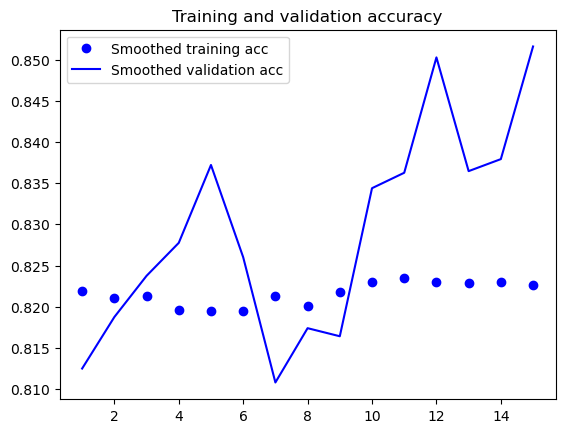

<Figure size 640x480 with 0 Axes>

In [61]:
# Create a new array of epoch values
epochs = range(1, len(history2.history['accuracy']) + 1)

# Plot the smoothed training and validation accuracy values against the epochs
plt.plot(epochs, smooth_curve(history2.history['accuracy']), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(history2.history['val_accuracy']), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

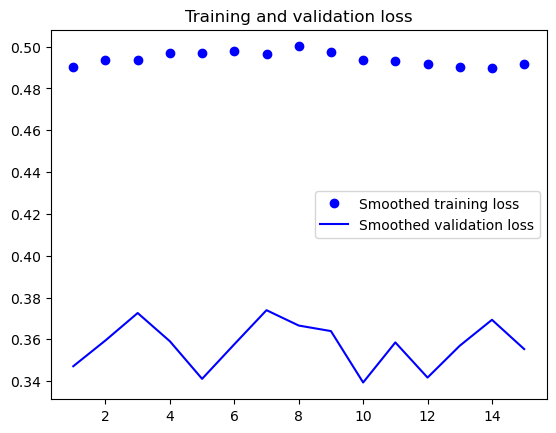

<Figure size 640x480 with 0 Axes>

In [62]:
# Create a new array of epoch values
epochs = range(1, len(history2.history['loss']) + 1)

# Plot the smoothed training and validation accuracy values against the epochs
plt.plot(epochs, smooth_curve(history2.history['loss']), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(history2.history['val_loss']), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


In [63]:
# Calculate the predictions on the validation set
val_generator.reset()
y_pred = model2.predict(val_generator, steps=len(val_generator))
y_pred = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 302ms/step


In [64]:
# calculate precision, recall, f1-score, and support for each class
class_report = classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys())
print(class_report)

              precision    recall  f1-score   support

         CNV       0.09      0.12      0.11         8
         DME       0.12      0.12      0.12         8
      DRUSEN       0.00      0.00      0.00         8
      NORMAL       0.00      0.00      0.00         8

    accuracy                           0.06        32
   macro avg       0.05      0.06      0.06        32
weighted avg       0.05      0.06      0.06        32



# evaluate the model on the test data

In [65]:
# Evaluate the model on the train generator
train_loss, train_acc = sum(history2.history['loss'])/len(history2.history['loss']),sum(history2.history['accuracy'])/len(history2.history['accuracy'])
print("Train accuracy:", train_acc)
print("Train loss:", train_loss)
print(80 * '_')

# Evaluate the model on the validation generator
val_loss, val_acc = model2.evaluate(val_generator, verbose=0)
print("Validation accuracy:", val_acc)
print("Validation loss:", val_loss)
print(80 * '_')

# Evaluate the model on the test generator
test_loss, test_acc = model2.evaluate(test_generator, verbose=0)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

Train accuracy: 0.8218053340911865
Train loss: 0.4946177065372467
________________________________________________________________________________
Validation accuracy: 0.8125
Validation loss: 0.4457867443561554
________________________________________________________________________________
Test accuracy: 0.8564049601554871
Test loss: 0.3658451437950134


In [67]:
# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(test_generator)

# Make predictions on the test set
test_generator.reset()
y_pred = model2.predict(test_generator, verbose=1)
predictions = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute the precision, recall, and f1 score
print(classification_report(y_true, predictions))

16/16 [==============================] - 8s 512ms/step
              precision    recall  f1-score   support

           0       0.32      0.42      0.36       242
           1       0.25      0.21      0.23       242
           2       0.25      0.18      0.21       242
           3       0.27      0.30      0.28       242

    accuracy                           0.28       968
   macro avg       0.27      0.28      0.27       968
weighted avg       0.27      0.28      0.27       968



after training the two CNN models on the OCT dataset, then the vgg16 model give better performance